## Logistic Regression Workout

ROC Curves: One of the best ways to evaluate how a classifier performs is a ROC-Curve.

The data we will be using is admission data on Grad school acceptances.

- admit: whether or not the applicant was admitted to grad. school
- gpa: undergraduate GPA
- gre: score of GRE test
- rank: prestige of undergraduate school (1 is highest prestige, ala Harvard)

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import pandas as pd

In [20]:
df = pd.read_csv('data/grad.csv')

In [21]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


We will use the GPA, GRE, and rank of the applicants to try to predict whether or not they will be accepted into graduate school.

Lets see what is going on with the data.

In [22]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 12.6 KB


Lets use the pandas crosstab method to see how many applicants from each rank of school were accepted. 

In [24]:
admit = pd.crosstab(df['admit'], df['rank'], rownames=['admit'])

In [25]:
admit

rank,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


A bar plot of the percent of applicants from each rank who were accepted. You can do .plot(kind="bar") on a pandas dataframe.

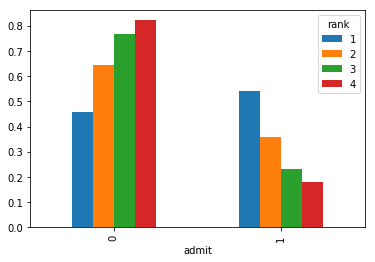

In [26]:
import matplotlib.pyplot as plt

(admit / admit.apply(sum)).plot(kind="bar")
plt.show()

I am highly interested in the distribution of the GPA and GRE scores. Do the distributions differ much.

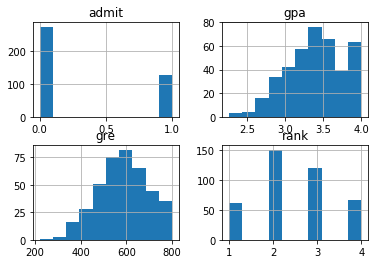

In [27]:
df.hist()
plt.show()

Too small.

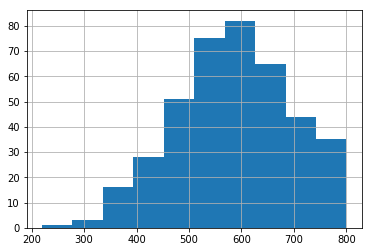

In [28]:
df.gre.hist()
plt.show()

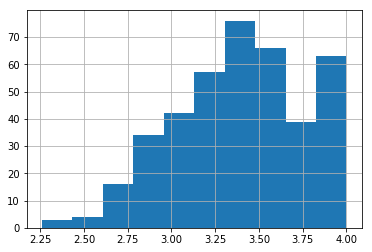

In [29]:
df.gpa.hist()
plt.show()

The distributions of GPA and GRE actually look quite similar, possibly normally distributed slightly skewed to the left (negative skew) centered around the means of GPA and GRE computed above. And for GPAs there is an anomolous bump near 4.0s.

One of the issues with the classification is the unbalanced classes. Lets if that is a case in our senario.

In [30]:
df.admit.sum() / df.shape[0]

0.3175

or even better

In [31]:
print(df['admit'].value_counts() / len(df))

0    0.6825
1    0.3175
Name: admit, dtype: float64


Classes aren't too imbalanced so you should be fine. When dealing with data where the label could potentially be something that is biased one way or the other (such as acceptance, fraud, signups, anything where one label is more preferential to the other or deals with some measure of "success") you should verify. Actually you should most always verify.

### Prediction

In [32]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

X = df[['gre', 'gpa', 'rank']].values
X_const = add_constant(X, prepend=True)
y = df['admit'].values

logit_model = Logit(y, X_const).fit()

Optimization terminated successfully.
         Current function value: 0.574302
         Iterations 6


Lets use summary method to see our results.The p-values for the beta coefficients are important. We would like these to be significant. I hope they are because we have only a couple of features(on the other hand less is better for a low number of observations).

How do we understand if our features are important? P-value shall be a small one such as < 0.05

In [33]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:                 0.08107
Time:                        21:01:40   Log-Likelihood:                -229.72
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 8.207e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4495      1.133     -3.045      0.002      -5.670      -1.229
x1             0.0023      0.001      2.101      0.036       0.000       0.004
x2             0.7770      0.327      2.373      0.018       0.135       1.419
x3            -0.5600      0.127     -4.405      0.000      -0.809      -0.311
==============================================================================
"""

Aha! the highest p-value is 0.036 which means all of our features are significant. Okay we are comfortable with our model. Lets proceed with the cross validation.

At following we will use use ***sklearn's KFold cross validation*** and ***LogisticRegression*** to calculate the ***average accuracy, precision and recall***

a fine reading here:

https://towardsdatascience.com/5-reasons-why-you-should-use-cross-validation-in-your-data-science-project-8163311a1e79

In [34]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import datasets
from sklearn import svm

In [36]:
from sklearn.model_selection import KFold, RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

accuracies = []
precisions = []
recalls = []


# we will do this as many as number of splits
for train_index, test_index in kf.split(X):
    
    #get train test split from splitted X
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    #create da model
    model = LogisticRegression()
    model.fit(X[train_index], y[train_index])
    
    #get predictions and actual values for target(y)
    y_predict = model.predict(X[test_index])
    y_true = y[test_index]
    
    #get da scores for the horde
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print(len(accuracies))
# the truth is the average


50


The results with the cross validation

In [37]:
# the result with cross 
print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))

accuracy: 0.70025
precision: 0.5990574556162791
recall: 0.20232683321687506


The rank column is ordinal where we assume an equal change between ranking levels, but we could also consider it to be more generally categorical. Use panda's get_dummies to binarize the column.

In [38]:
dummies = pd.get_dummies(df['rank'], prefix='rank')
X2 = df[['gre','gpa']].join(dummies.ix[:,'rank_1':])

In [39]:
dummies.head(1)

,rank_1,rank_2,rank_3,rank_4
0,0,0,1,0


In [40]:
X2.head(1)

,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,380,3.61,0,0,1,0


Lets do the same again to see the difference in scores

In [41]:
# we will do this as many as number of splits
for train_index, test_index in kf.split(X):
    
    #get train test split from splitted X
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    #create da model
    model = LogisticRegression()
    model.fit(X[train_index], y[train_index])
    
    #get predictions and actual values for target(y)
    y_predict = model.predict(X[test_index])
    y_true = y[test_index]
    
    #get da scores for the horde
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print(len(accuracies))
# the truth is the average

100


It seem to perform worse..

In [42]:
print("accuracy:", np.average(accuracies))
print("precision:", np.average(precisions))
print("recall:", np.average(recalls))

accuracy: 0.6993749999999999
precision: 0.6023737994032111
recall: 0.19777891209907203


***Say we are using this as a first step in the application process. We want to weed out clearly unqualified candidates, but not reject too many candidates. What might be a good choice of threshold?***

From a ROC curve point of view, where positive = "unqualified"
- task: "clear out unqualified but don't reject too much
- FPR = "The aplicant is qualified yet the model predicts she is unqualified." -> shall be low
- TPR = "The aplicant is unqualified and model predictts she is unqualified." -> shall be high

Therefore we need a treshold that minimizes FPR and Maximizes TPR.

In [43]:
y.shape

(400,)

In [46]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2, y)


logit_model = LogisticRegression().fit(X_train, y_train)

y_pred = logit_model.predict(X_test)
y_prob = logit_model.predict_proba(X_test)[:, 1]

treshholds = np.linspace(0,1,100)

In [47]:
from sklearn.metrics import auc, roc_curve

def plot_roc(fpr, tpr, auc_score):
    plt.figure(figsize=(6, 6))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label='AUC = {:5.2f}'.format(auc_score))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.01,1.01])
    plt.ylim([-0.01,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return

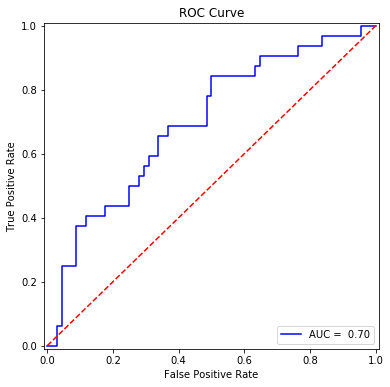

In [48]:
# Compute ROC and AUC`
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score = y_prob)
auc_score = auc(fpr, tpr)

plot_roc(fpr, tpr, auc_score)

We want to maximize the TPR and don't care as much about the FPR. With a threshold of 0.788, we can get a TPR of 96.9%. THe FPR will be 73.5%, but we are okay with this sacrifice in order to avoid false negatives.